In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time

In [7]:
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = -1

In [5]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/ERAA_scandinavie"
output_path = study_path+"/user/fast_fi00"

In [8]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

def modify_objective(model, u):
    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
    model.chgrhs(binding_id,[u])
    return(model)

def milp_version(model):
    vars = model.getVariable()
    interger_vars = [i for i in range(len(vars)) if vars[i].name.strip().split("::")[0] in ['NODU', 'NumberBreakingDownDispatchableUnits', 'NumberStartingDispatchableUnits','NumberStoppingDispatchableUnits']]
    for i in interger_vars:
        model.chgcoltype([vars[i]],'I')
    return(model)

In [10]:
S = 52
n_controls = 9
reward = read_r(study_path+"/user/reward_9sim_fast_fi00.RData")
reward = reward['reward']
U = reward['control'].values.reshape((S,n_controls))

In [11]:
max_turb = U[:,-1]

In [39]:
n_controls = 100
U = np.array([np.linspace(0,max_turb[i],num=n_controls) for i in range(S)])

In [40]:
s=0
k = 0
reward = np.zeros((n_controls,2))
simplex_itr = np.zeros((n_controls,2))

m = xp.problem()
m.read(output_path+f"/problem-{k+1}-{s+1}--optim-nb-{1}.mps")
m.controls.xslp_log = -1
cst = m.getConstraint()
binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

for u in range(n_controls):
    print(f"{u}  ",end="\r") 
    m.chgrhs(binding_id,[U[s,u]])
    debut = time()
    m.lpoptimize()
    fin = time()
    reward[u,0] =  m.getObjVal() 
    reward[u,1] = m.getDual(binding_id)[0]
    simplex_itr[u,0] = m.attributes.SIMPLEXITER
    simplex_itr[u,1] = fin-debut

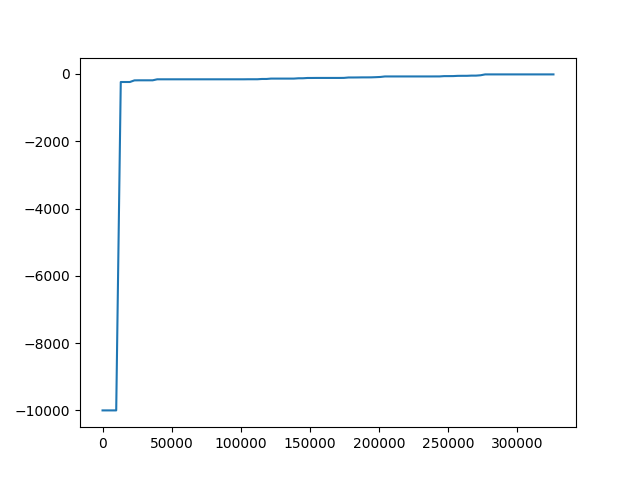

In [41]:
plt.figure()
plt.plot(U[s],reward[:,1])

In [42]:
reward[:,1]

array([-9999.99997725, -9999.98887999, -9999.98887999, -9999.98887999,
        -239.98994042,  -239.98994042,  -239.98994042,  -191.65705447,
        -189.72693138,  -189.72692846,  -189.72588478,  -189.72585742,
        -159.9899611 ,  -159.9899611 ,  -159.9899611 ,  -159.9899611 ,
        -159.9899611 ,  -159.9899611 ,  -159.9899611 ,  -159.9899611 ,
        -159.9899611 ,  -159.9899611 ,  -159.9899611 ,  -159.9899611 ,
        -159.9899611 ,  -159.9899611 ,  -159.9899611 ,  -159.9899611 ,
        -159.9899611 ,  -159.9899611 ,  -159.9899611 ,  -159.9899611 ,
        -158.43395271,  -158.43291166,  -158.43050446,  -149.99882299,
        -149.98885407,  -138.83996181,  -138.83996181,  -138.83994757,
        -138.8399367 ,  -138.83882399,  -138.83882399,  -129.53602063,
        -129.15694968,  -120.37537074,  -120.31512489,  -119.15194   ,
        -119.15194   ,  -119.15194   ,  -119.15194   ,  -119.15194   ,
        -119.15194   ,  -117.95821441,  -105.7419545 ,  -105.71219854,
      

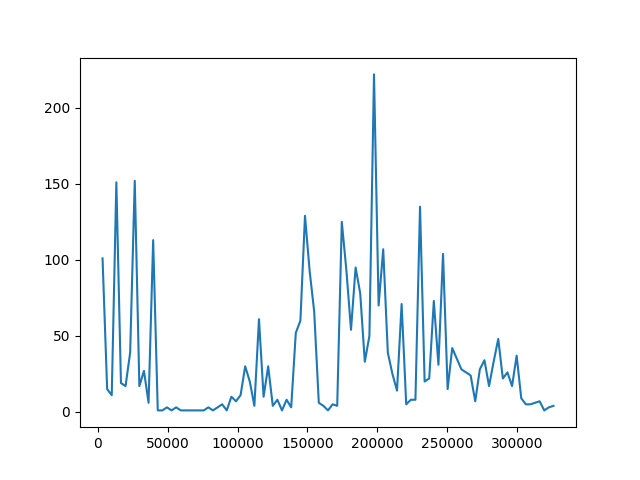

In [43]:
plt.figure()
plt.plot(U[s][1:],simplex_itr[1:,0])

In [44]:
np.sum(simplex_itr[:,0]>0)

100

In [64]:
s=0
k = 0
eps = 10
controls = []
itr = []

m = xp.problem()
m.read(output_path+f"/problem-{k+1}-{s+1}--optim-nb-{1}.mps")
m.controls.xslp_log = -1
cst = m.getConstraint()
binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

u = U[s,0]
while u <= U[s,-1]:
    print(f"{u}  ",end="\r") 
    m.chgrhs(binding_id,[u])
    debut = time()
    m.lpoptimize()
    fin = time()
    controls.append(u)
    itr.append(m.attributes.SIMPLEXITER)
    low = []
    up = []
    m.rhssa(binding_id, low, up)
    if u < up[0]:
        u = up[0]
    else :
        u += eps

In [65]:
len(controls)

6662

In [66]:
controls = np.array(controls)

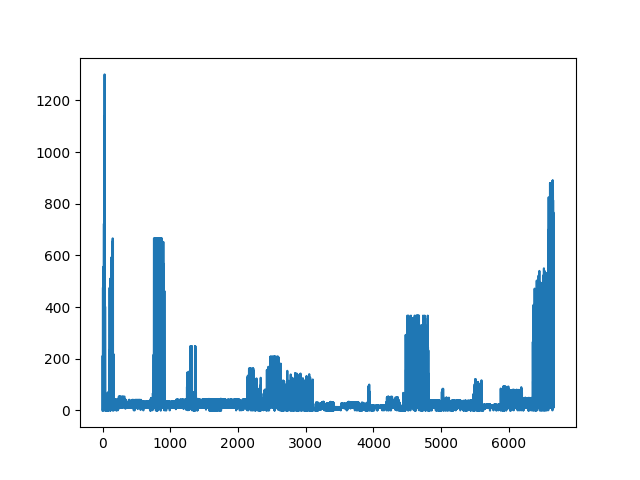

In [67]:
plt.figure()
plt.plot(controls[1:]-controls[:-1])

In [68]:
np.sum(np.array(itr)>0)

4188